In [1]:
import numpy as np
from scipy.optimize import minimize, minimize_scalar, NonlinearConstraint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.linalg import LinAlgError
import pandas as pd
from scipy.stats import norm
from statsmodels.regression.linear_model import OLS
import scipy.stats as stats

In [2]:
#pip install statsmodels

# Define the LS estimator

In [3]:
def d_alpha_fun(alpha):
    if alpha == 0:
        return np.log
    elif alpha > 0:
        return lambda x: -1/x**alpha
    else:
        return print("alpha must be >= 0")

In [4]:
def d_alpha_inv_fun(alpha):
    if alpha == 0:
        return np.exp
    elif alpha > 0:
        return lambda x: (-1/x)**(1/alpha)
    else:
        return print("alpha must be >= 0")

In [5]:
d_alpha = d_alpha_fun(0.5)
d_alpha_inv = d_alpha_inv_fun(0.5)

In [6]:
def convex_matrix(w):
    n = len(w)
    A = np.zeros((n-1, n))

    for i in range(n-1):
        A[i, i] = -1 / (w[i+1] - w[i])
        A[i, i+1] = 1 / (w[i+1] - w[i])

    return A

# Example: create a matrix with a vector w
w_vector = np.array([1, 2, 4, 7, 11])
matrix_A =  convex_matrix(w_vector)

print("Matrix A:")
print(matrix_A)

Matrix A:
[[-1.          1.          0.          0.          0.        ]
 [ 0.         -0.5         0.5         0.          0.        ]
 [ 0.          0.         -0.33333333  0.33333333  0.        ]
 [ 0.          0.          0.         -0.25        0.25      ]]


In [7]:
def objective_function(vector, y_s, d_alpha_inv):
    return np.sum((y_s - d_alpha_inv(vector))**2)

def constraint(vector, w, d_alpha, epsi):
    return np.concatenate([
        d_alpha(epsi) - vector,
        -d_alpha(1 - epsi) + vector,
        np.dot(convex_matrix(w), vector),
        np.diff(np.dot(convex_matrix(w), vector))
    ])

def LS(w, y, d_alpha, d_alpha_inv, epsi):
    w_unique = np.unique(w)
    n = len(w_unique)
    w_sorted = np.sort(w_unique)
    index = np.argsort(w)

    y_s = [y[i] for i in index]
    y_s = np.array(y_s, dtype=int)

    # Initial guess for alpha
    vector0 = -np.ones(n)

    # Define the objective and constraints for scipy.optimize
    obj_func = lambda vector: objective_function(vector, y_s, d_alpha_inv)
    nonlinear_constraint = NonlinearConstraint(lambda vector: constraint(vector,w_sorted, d_alpha, epsi), -np.inf, 0)

    # Minimize the objective function subject to constraints
    result = minimize(obj_func, vector0, constraints=[nonlinear_constraint])

    phi = result.x
    F_hat = interp1d(w_sorted, 1-d_alpha_inv(phi), kind='linear', fill_value='extrapolate')
    return F_hat

## EXAMPLE: Estimate the CDF of a N(0,1)

In [8]:
epsi= 10**(-15)
n_points = 100
w_example = np.random.uniform(-2, 2, n_points)
y_example = np.where(np.random.normal(0, 1, n_points) > w_example, 1, 0)

result = LS(w_example, y_example, d_alpha, d_alpha_inv, epsi)
F_bar = 1-result(np.sort(w_example))
phi = -1/F_bar

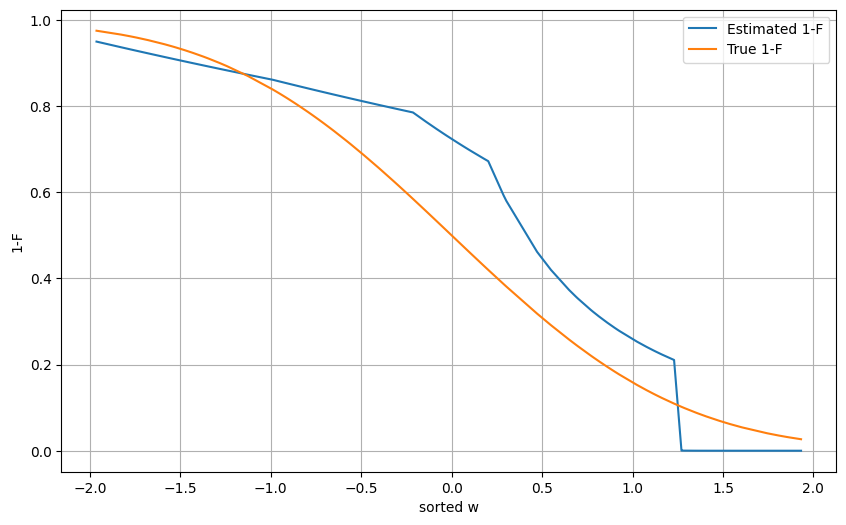

In [9]:
complement_cdf = 1-norm.cdf(np.sort(w_example))

plt.figure(figsize=(10, 6))
plt.plot(np.sort(w_example), F_bar, label='Estimated 1-F')
plt.plot(np.sort(w_example), complement_cdf, label='True 1-F')
plt.xlabel('sorted w')
plt.ylabel('1-F')

plt.legend()
plt.grid(True)
plt.show()

# CODE

### Define parameters

#### Twice not third times differentiable

In [10]:
#def cdf_0(x):
#    sign_x = np.sign(x)
#    abs_x = np.abs(x)    
#    term1 = -1/14 * x * (-28 + 3 * abs_x**(4/3) + 3 * abs_x**(4/3) + 3 * ((abs_x)**(1/3) + abs_x**(1/3)) * x * sign_x)
#    term2 = 0.5
#    val = term1 + term2
#    return 0 if x < -0.25 else 1 if x > 0.25 else val

#### N(0,1)

In [11]:
cdf_0 = stats.norm.cdf #True F_0

In [12]:
epsi = 1e-12 # Lower bound of F_0
d = 2 # Dimension of features
H = 6 # Maximum price
q = 3  # Degree of differentiability of F_hat
tau_0 = 100 # Lenght of the first episode
interc_0 = 3 # True intercept of theta
slope_0 = np.repeat(np.sqrt(2 / 3), d) # True slope of theta
theta_0 = np.concatenate(([interc_0], slope_0))
max_eval = 5 # Maximum number of evaluations (for Confidence Intervals)

### Define Optimal pricing function

In [13]:
from scipy.optimize import minimize

def g_opt(q, F):
    x0 = 0.5 * H  # Adjust the initial guess as needed
    result = minimize(lambda p: -p * (1 - F(p - q)), x0=x0, method='L-BFGS-B', bounds=[(0, H)])
    
    optimal_p = result.x[0]
    return 0 if optimal_p < 0 else H if optimal_p > H else optimal_p

### Distribution of X: support is $[-\sqrt{2/3},\sqrt{2/3}]$

In [14]:
const_x = 128 * np.sqrt(6) / 2835
def F_x(x):
    return (-x**7 / 7 + 2 * x**5 / 5 - 4 * x**3 / 9 + 8 * x / 27 + const_x) / (2 * const_x)

range_x = np.linspace(-np.sqrt(2 / 3), np.sqrt(2 / 3), num=10000)
F_x_val = np.array([F_x(x) for x in range_x])

# Sample N iid x_t of dimension d. Return design matrix with d+1 columns
def Sample_x(N, d):
    u = np.random.uniform(0, 1, d * N)
    x_sample = np.array([range_x[np.argmin(np.abs(F_x_val - u_j))] for u_j in u])
    X = x_sample.reshape((N, d))
    X_tilde = np.column_stack((np.ones(N), X))
    return X_tilde

### Sample from Z: support is $[-0.25,0.25]$

In [15]:
range_z = np.linspace(-0.25,0.25, num=10000)
F_z_val = np.array([cdf_0(x) for x in range_z])

def Sample_z(N):
    u = np.random.uniform(0, 1, N)
    z_sample = np.array([range_z[np.argmin(np.abs(F_z_val - u_j))] for u_j in u])
    return z_sample

In [16]:
# TEST WITH cdf_0 = N(0,1)
#n = 10000
#data = Sample_z(n)
#plt.hist(data, bins=30, density=True, alpha=0.7, color='blue', label='Histogram')

# Plot the PDF of a standard normal distribution (N(0, 1))
#x = np.linspace(-4, 4, 1000)
#pdf_values = norm.pdf(x, loc=0, scale=1)
#plt.plot(x, pdf_values, 'r-', label='N(0,1) PDF')

# Add labels and a legend
#plt.xlabel('Value')
#plt.ylabel('Probability Density')
#plt.title('Histogram and N(0,1) PDF Comparison')
#plt.legend()

# Show the plot
#plt.show()

### Kernel functions and Non-Parametric estimation of $F_0$

In [17]:
# Kernel (Yonki paper)
def kernel(x, m):
    if m == 2:
        val_2 = (1 - x**2)**3 * np.where(np.abs(x) < 1, 35 / 12, 0)
        return val_2
    elif m == 4:
        val_2 = (1 - x**2)**3 * np.where(np.abs(x) < 1, 35 / 12, 0)
        val_4 = (1 - 11 / 3 * x**2) * val_2 * 27 / 16
        return val_4
    elif m == 6:
        val_2 = (1 - x**2)**3 * np.where(np.abs(x) < 1, 35 / 12, 0)
        val_6 = (1 - 26 / 3 * x**2 + 13 * x**4) * val_2 * 297 / 128
        return val_6

# Kernel prime
def kernel_prime(x, m):
    if m == 2:
        val_2_prime = -x * (1 - x**2)**2 * np.where(np.abs(x) < 1, 35 / 2, 0)
        return val_2_prime
    elif m == 4:
        val_2 = (1 - x**2)**3 * np.where(np.abs(x) < 1, 35 / 12, 0)
        val_2_prime = -x * (1 - x**2)**2 * np.where(np.abs(x) < 1, 35 / 2, 0)
        val_4_prime = (-27 / 16) * (11 / 3) * 2 * x * val_2 + (1 - 11 / 3 * x**2) * val_2_prime * 27 / 16
        return val_4_prime
    elif m == 6:
        val_2 = (1 - x**2)**3 * np.where(np.abs(x) < 1, 35 / 12, 0)
        val_2_prime = -x * (1 - x**2)**2 * np.where(np.abs(x) < 1, 35 / 2, 0)
        val_6_prime = (-(26 / 3) * 2 * x + 13 * 4 * x**3) * val_2 * (297 / 128) + (
                    1 - 26 / 3 * x**2 + 13 * x**4) * val_2_prime * 297 / 128
        return val_6_prime

# Kernel method for NP (Yonki)
def Yonki_NP(w, y, m):
    w = np.unique(w)
    n = len(w)
    w_s = np.sort(w)
    values = np.linspace(min(w_s), max(w_s), num=n)
    index = np.argsort(w)
    y_s = [y[i] for i in index]

    b = 3 * n**(-1 / (2 * m + 1))

    def h(u):
        return np.array([np.dot(kernel((w_s - u_i) / b, m).T, y_s) / (n * b) for u_i in u])

    def h_prime(u):
        return np.array([-np.dot(kernel_prime((w_s - u_i) / b, m).T, y_s) / (n * b**2) for u_i in u])

    def f(u):
        return np.array([np.sum(kernel((w_s - u_i) / b, m)) / (n * b) for u_i in u])

    def f_prime(u):
        return np.array([-np.sum(kernel_prime((w_s - u_i) / b, m)) / (n * b**2) for u_i in u])

    def F_hat(u):
        return 1 - h(u) / f(u)

    def F_hat_prime(u):
        return -(h_prime(u) * f(u) - h(u) * f_prime(u)) / (f(u)**2)

    def varphi_hat(u):
        a = u - (1 - F_hat(u)) 
        b = F_hat_prime(u)
        c = np.where(np.abs(b) < 1e-8, 1e-6, b)
        return a/c

    F_hat_v = F_hat(values)
    F_hat_prime_v = F_hat_prime(values)
    varphi_hat_v = varphi_hat(values)

    F_hat = interp1d(w_s, F_hat_v, kind='linear', fill_value='extrapolate')
    return F_hat

### Exploration and Estimation of $\theta_0$ and $F_0$

In [18]:
def exploration_and_estimation(k):
    tau_k = tau_0 * 2**(k-1)
    tau_kplus1 = tau_0 * 2**k

    a_k = np.ceil(tau_k**(5/7))
    a_k_Yonki = np.ceil((tau_k * d)**((2*m+1)/(4*m-1)))

    # Exploration phase set
    I_k = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k)
    I_k_Yonki = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k_Yonki)

    # Exploitation phase set
    I_k_prime = np.arange(tau_k - tau_0 + a_k, tau_kplus1 - tau_0)
    I_k_prime_Yonki = np.arange(tau_k - tau_0 + a_k_Yonki, tau_kplus1 - tau_0)

    # Sample from X
    X_tilde = Sample_x(len(I_k), d)
    X_tilde_Yonki = Sample_x(len(I_k_Yonki), d)

    # Sample from X
    Z_t = Sample_z(len(I_k))
    Z_t_Yonki = Sample_z(len(I_k_Yonki))

    # Exploration phase
    c_t = np.random.uniform(0, H, len(I_k))
    c_t_Yonki = np.random.uniform(0, H, len(I_k_Yonki))

    V_t = Z_t + np.dot(X_tilde, theta_0)
    V_t_Yonki = Z_t_Yonki + np.dot(X_tilde_Yonki, theta_0)

    Y_t = V_t > c_t
    Y_t_Yonki = V_t_Yonki > c_t_Yonki

    c_explor_opt = [g_opt(a,cdf_0) for a in np.dot(X_tilde, theta_0)]
    c_explor_opt_Yonki = [g_opt(a,cdf_0) for a in np.dot(X_tilde_Yonki, theta_0)]

    regret_explor = c_explor_opt * (V_t > c_explor_opt).astype(int) - c_t * (V_t > c_t).astype(int)
    regret_explor_Yonki = c_explor_opt_Yonki * (V_t_Yonki > c_explor_opt_Yonki).astype(int) - c_t_Yonki * (V_t_Yonki > c_t_Yonki).astype(int)    
    
    mod = OLS(H * Y_t, X_tilde).fit()
    mod_Yonki = OLS(H * Y_t_Yonki, X_tilde_Yonki).fit()
    
    theta_hat_k = mod.params
    theta_hat_k_Yonki = mod_Yonki.params
    
    W_t = c_t - np.dot(X_tilde, theta_hat_k)
    W_t_Yonki = c_t_Yonki - np.dot(X_tilde_Yonki, theta_hat_k_Yonki)
      
    #print("Computing NPMLE and Yonki")
    F_k = LS(W_t, Y_t, d_alpha, d_alpha_inv, epsi)
    F_k_Yonki = Yonki_NP(W_t_Yonki, Y_t_Yonki,m)

    return {"I_k_prime":I_k_prime, "theta_hat_k":theta_hat_k, "F_k":F_k, "c_explor_opt":c_explor_opt, "regret_explor":regret_explor, "I_k_prime_Yonki":I_k_prime_Yonki, "theta_hat_k_Yonki":theta_hat_k_Yonki, "F_k_Yonki":F_k_Yonki, "c_explor_opt_Yonki":c_explor_opt_Yonki, "regret_explor_Yonki":regret_explor_Yonki}
    

### Exploitation

In [19]:
def exploitation(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki):
    # NPMLE
    c_hat = []
    W_exploit = []
    Y_exploit = []
    c_exploit_opt = []
    regret_exploit = []

    # Yonki
    c_hat_Yonki = []
    W_exploit_Yonki = []
    Y_exploit_Yonki = []
    c_exploit_opt_Yonki = []
    regret_exploit_Yonki = []
    
    # NMPLE
    for t in I_k_prime:
        x_exploit = Sample_x(1, d)
        g_k = g_opt(x_exploit @ theta_hat_k, F_k)
        c_exploit = np.clip(g_k, 0, H)
        Z_t = Sample_z(1)
        V_t = Z_t + x_exploit @ theta_0
        y_exploit = V_t > c_exploit
        w_exploit = c_exploit - x_exploit @ theta_hat_k
    
        # Optimal true price
        opt_price = g_opt(x_exploit @ theta_0,cdf_0)
        regret_exploit.append(opt_price * (V_t > opt_price) - c_exploit * (V_t > c_exploit))
        c_exploit_opt.append(opt_price)
    
        # Updates
        c_hat.append(c_exploit)
        W_exploit.append(w_exploit)
        Y_exploit.append(y_exploit)
    
    
    # Yonki
    for t in I_k_prime_Yonki:
        x_exploit = Sample_x(1, d)
        g_k_Yonki = g_opt(x_exploit @ theta_hat_k_Yonki, F_k_Yonki)
        c_exploit_Yonki = np.clip(g_k_Yonki, 0, H)
        Z_t = Sample_z(1)
        V_t = Z_t + x_exploit @ theta_0
        y_exploit_Yonki = V_t > c_exploit_Yonki
        w_exploit_Yonki = c_exploit_Yonki - x_exploit @ theta_hat_k_Yonki
    
        # Optimal true price
        opt_price_Yonki = g_opt(x_exploit @ theta_0, cdf_0)
        regret_exploit_Yonki.append(opt_price_Yonki * (V_t > opt_price_Yonki) - c_exploit_Yonki * (V_t > c_exploit_Yonki))
        c_exploit_opt_Yonki.append(opt_price_Yonki)
    
        # Updates
        c_hat_Yonki.append(c_exploit_Yonki)
        W_exploit_Yonki.append(w_exploit_Yonki)
        Y_exploit_Yonki.append(y_exploit_Yonki)

    return {"c_exploit_opt":c_exploit_opt, "regret_exploit":regret_exploit, "c_exploit_opt_Yonki":c_exploit_opt_Yonki, "regret_exploit_Yonki":regret_exploit_Yonki}

### Updates and collect regret

In [20]:
def updates_and_collenct_info(c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki, c_explor_opt, regret_explor, c_explor_opt_Yonki, regret_explor_Yonki, Regret, Regret_Yonki):   
  # Updates
  #c_exploit_opt = [float(arr[0]) for arr in c_exploit_opt]
  #c_exploit_opt_Yonki = [float(arr[0]) for arr in c_exploit_opt_Yonki]

  c_opt = np.concatenate((c_explor_opt, c_exploit_opt))
  c_opt_Yonki = np.concatenate((c_explor_opt_Yonki, c_exploit_opt_Yonki))

  # Regret
  regret_exploit = [float(arr[0]) for arr in regret_exploit]
  regret_exploit_Yonki = [float(arr[0]) for arr in regret_exploit_Yonki]

  reg_k = np.concatenate((regret_explor, regret_exploit)).tolist()
  reg_k_Yonki = np.concatenate((regret_explor_Yonki, regret_exploit_Yonki)).tolist()
  
  Regret = np.concatenate((Regret, reg_k))
  Regret_Yonki = np.concatenate((Regret_Yonki, reg_k_Yonki))

  return {"Regret": Regret, "Regret_Yonki": Regret_Yonki}

### Plot the cumulative regret

In [21]:
def plot_results(Regret_eval,Regret_eval_Yonki):
  cumulative_regret = np.cumsum(Regret_eval, axis=0)

  nan_columns = np.any(np.isnan(Regret_eval_Yonki), axis=0)
  Regret_eval_Yonki = Regret_eval_Yonki[:, ~nan_columns]
  cumulative_regret_Yonki = np.cumsum(Regret_eval_Yonki, axis=0)

  horiz_T_NPMLE = cumulative_regret.shape[0]
  horiz_T_Yonki = cumulative_regret_Yonki.shape[0]

  T_NPMLE = np.arange(1, horiz_T_NPMLE + 1)
  T_Yonki = np.arange(1, horiz_T_Yonki + 1)
  # Quantiles for shading along each row
  q_5_NPMLE = np.percentile(cumulative_regret, 5, axis=1)
  q_95_NPMLE = np.percentile(cumulative_regret, 95, axis=1)
  q_5_Yonki = np.percentile(cumulative_regret_Yonki, 5, axis=1)
  q_95_Yonki = np.percentile(cumulative_regret_Yonki, 95, axis=1)

  # Se m=2, crea la finestra con 3 colonne
  if m == 2:
    axs[0].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[0].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[0].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[0].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("regret")
    axs[0].set_title(f"m = {m}")

  # Se m=4, aggiungi un plot al centro e la legenda
  elif m == 4:
    axs[1].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[1].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[1].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[1].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("regret")
    axs[1].set_title(f"m = {m}")
    axs[1].legend(["LS", "Kernel"], loc="upper left", frameon=False)

  # Se m=6, aggiungi l'ultimo plot a destra
  elif m == 6:
    axs[2].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[2].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[2].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[2].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[2].set_xlabel("t")
    axs[2].set_ylabel("regret")
    axs[2].set_title(f"m = {m}")

### MAIN

m =  2
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
m =  4
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3
m =  6
Evaluation 0
Episode 1
Episode 2
Episode 3
Evaluation 1
Episode 1
Episode 2
Episode 3
Evaluation 2
Episode 1
Episode 2
Episode 3
Evaluation 3
Episode 1
Episode 2
Episode 3
Evaluation 4
Episode 1
Episode 2
Episode 3


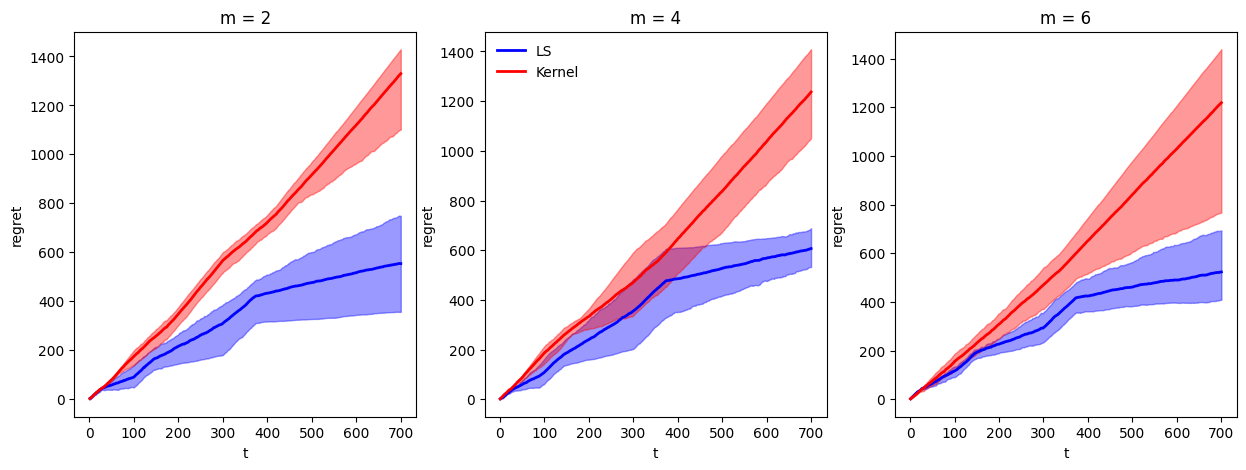

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m in {2,4,6}:
  print("m = ", m)
  for eval in range(max_eval):
    print("Evaluation", eval)
    np.random.seed(eval+1)
    Regret = []
    Regret_Yonki = []
    
    for k in range(1, 4):
      print("Episode", k)
      explor = exploration_and_estimation(k)
      
      I_k_prime, theta_hat_k, F_k, c_explor_opt, regret_explor, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki, c_explor_opt_Yonki, regret_explor_Yonki = explor.values()
      exploit = exploitation(I_k_prime, theta_hat_k, F_k, I_k_prime_Yonki, theta_hat_k_Yonki, F_k_Yonki)
      
      c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki = exploit.values()
      update = updates_and_collenct_info(c_exploit_opt, regret_exploit, c_exploit_opt_Yonki, regret_exploit_Yonki, c_explor_opt, regret_explor, c_explor_opt_Yonki, regret_explor_Yonki, Regret, Regret_Yonki)
      Regret, Regret_Yonki = update.values()
    
    if eval == 0:
      Regret_eval = np.array(Regret)
      Regret_eval_Yonki = np.array(Regret_Yonki)
    else:
      Regret_eval = np.column_stack((Regret, Regret_eval))
      Regret_eval_Yonki = np.column_stack((Regret_Yonki, Regret_eval_Yonki))
        
  plot_results(Regret_eval,Regret_eval_Yonki)
    
plt.savefig('regret.png')

### This is the same functions but with all the pieces toghether

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for m in {2,4,6}:
  max_eval = 10

  for eval in range(max_eval):
    np.random.seed(eval+1)

    # Set up parameters
    epsi = 1e-12
    d = 2
    H = 6
    q = 3  # degree of differentiability of F_hat
    tau_0 = 100
    interc_0 = 3
    slope_0 = np.repeat(np.sqrt(2 / 3), d)
    theta_0 = np.concatenate(([interc_0], slope_0))

    # Distribution of x
    const_x = 128 * np.sqrt(6) / 2835

    Regret = []
    Regret_Yonki = []

    for k in range(1, 4):
      # Length episode k
      print("Episode number", k)

      tau_k = tau_0 * 2**(k-1)
      tau_kplus1 = tau_0 * 2**k

      a_k = np.ceil(tau_k**(5/7))
      a_k_Yonki = np.ceil((tau_k * d)**((2*m+1)/(4*m-1)))

      # Exploration phase set
      I_k = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k)
      I_k_Yonki = np.arange(tau_k - tau_0, tau_k - tau_0 + a_k_Yonki)

      # Exploitation phase set
      I_k_prime = np.arange(tau_k - tau_0 + a_k, tau_kplus1 - tau_0)
      I_k_prime_Yonki = np.arange(tau_k - tau_0 + a_k_Yonki, tau_kplus1 - tau_0)

      # Sample from x
      X_tilde = Sample_x(len(I_k), d)
      X_tilde_Yonki = Sample_x(len(I_k_Yonki), d)

      Z_t = Sample_z(len(I_k))
      Z_t_Yonki = Sample_z(len(I_k_Yonki))

      # Exploration phase
      c_t = np.random.uniform(0, H, len(I_k))
      c_t_Yonki = np.random.uniform(0, H, len(I_k_Yonki))

      V_t = Z_t + np.dot(X_tilde, theta_0)
      V_t_Yonki = Z_t_Yonki + np.dot(X_tilde_Yonki, theta_0)

      Y_t = V_t > c_t
      Y_t_Yonki = V_t_Yonki > c_t_Yonki

      c_explor_opt = [g_opt(a,cdf_0) for a in np.dot(X_tilde, theta_0)]
      c_explor_opt_Yonki = [g_opt(a,cdf_0) for a in np.dot(X_tilde_Yonki, theta_0)]

      regret_explor = c_explor_opt * (V_t > c_explor_opt).astype(int) - c_t * (V_t > c_t).astype(int)
      regret_explor_Yonki = c_explor_opt_Yonki * (V_t_Yonki > c_explor_opt_Yonki).astype(int) - c_t_Yonki * (V_t_Yonki > c_t_Yonki).astype(int)

      mod = OLS(H * Y_t, X_tilde).fit()
      mod_Yonki = OLS(H * Y_t_Yonki, X_tilde_Yonki).fit()

      theta_hat_k = mod.params
      theta_hat_k_Yonki = mod_Yonki.params

      W_t = c_t - np.dot(X_tilde, theta_hat_k)
      W_t_Yonki = c_t_Yonki - np.dot(X_tilde_Yonki, theta_hat_k_Yonki)

      print("Computing NPMLE and Yonki")
      F_k = LS(W_t, Y_t, d_alpha, epsi)
      F_k_Yonki = Yonki_NP(W_t_Yonki, Y_t_Yonki,m)

      # NPMLE
      c_hat = []
      W_exploit = []
      Y_exploit = []
      c_exploit_opt = []
      regret_exploit = []

      # Yonki
      c_hat_Yonki = []
      W_exploit_Yonki = []
      Y_exploit_Yonki = []
      c_exploit_opt_Yonki = []
      regret_exploit_Yonki = []

      # NMPLE
      for t in I_k_prime:
          x_exploit = Sample_x(1, d)
          g_k = g_opt(x_exploit @ theta_hat_k, F_k)
          c_exploit = np.clip(g_k, 0, H)
          Z_t = Sample_z(1)
          V_t = Z_t + x_exploit @ theta_0
          y_exploit = V_t > c_exploit
          w_exploit = c_exploit - x_exploit @ theta_hat_k

          # Optimal true price
          opt_price = g_opt(x_exploit @ theta_0,cdf_0)
          regret_exploit.append(opt_price * (V_t > opt_price) - c_exploit * (V_t > c_exploit))
          c_exploit_opt.append(opt_price)

          # Updates
          c_hat.append(c_exploit)
          W_exploit.append(w_exploit)
          Y_exploit.append(y_exploit)


      # Yonki
      for t in I_k_prime_Yonki:
          x_exploit = Sample_x(1, d)
          g_k_Yonki = g_opt(x_exploit @ theta_hat_k_Yonki, F_k_Yonki)
          c_exploit_Yonki = np.clip(g_k_Yonki, 0, H)
          Z_t = Sample_z(1)
          V_t = Z_t + x_exploit @ theta_0
          y_exploit_Yonki = V_t > c_exploit_Yonki
          w_exploit_Yonki = c_exploit_Yonki - x_exploit @ theta_hat_k_Yonki

          # Optimal true price
          opt_price_Yonki = g_opt(x_exploit @ theta_0, cdf_0)
          regret_exploit_Yonki.append(opt_price_Yonki * (V_t > opt_price_Yonki) - c_exploit_Yonki * (V_t > c_exploit_Yonki))
          c_exploit_opt_Yonki.append(opt_price_Yonki)

          # Updates
          c_hat_Yonki.append(c_exploit_Yonki)
          W_exploit_Yonki.append(w_exploit_Yonki)
          Y_exploit_Yonki.append(y_exploit_Yonki)

      # Updates
      c_exploit_opt = [float(arr[0]) for arr in c_exploit_opt]
      c_exploit_opt_Yonki = [float(arr[0]) for arr in c_exploit_opt_Yonki]

      c_opt = np.concatenate((c_explor_opt, c_exploit_opt))
      c_opt_Yonki = np.concatenate((c_explor_opt_Yonki, c_exploit_opt_Yonki))

      # Regret
      regret_exploit = [float(arr[0]) for arr in regret_exploit]
      regret_exploit_Yonki = [float(arr[0]) for arr in regret_exploit_Yonki]

      reg_k = np.concatenate((regret_explor, regret_exploit)).tolist()
      reg_k_Yonki = np.concatenate((regret_explor_Yonki, regret_exploit_Yonki)).tolist()
      
      Regret = np.concatenate((Regret, reg_k))
      Regret_Yonki = np.concatenate((Regret_Yonki, reg_k_Yonki))
    
    if eval == 0:
      Regret_eval = np.array(Regret)
      Regret_eval_Yonki = np.array(Regret_Yonki)
    else:
      Regret_eval = np.column_stack((Regret, Regret_eval))
      Regret_eval_Yonki = np.column_stack((Regret_Yonki, Regret_eval_Yonki))

  cumulative_regret = np.cumsum(Regret_eval, axis=0)

  nan_columns = np.any(np.isnan(Regret_eval_Yonki), axis=0)
  Regret_eval_Yonki = Regret_eval_Yonki[:, ~nan_columns]
  cumulative_regret_Yonki = np.cumsum(Regret_eval_Yonki, axis=0)

  horiz_T_NPMLE = cumulative_regret.shape[0]
  horiz_T_Yonki = cumulative_regret_Yonki.shape[0]

  T_NPMLE = np.arange(1, horiz_T_NPMLE + 1)
  T_Yonki = np.arange(1, horiz_T_Yonki + 1)
  # Quantiles for shading along each row
  q_5_NPMLE = np.percentile(cumulative_regret, 5, axis=1)
  q_95_NPMLE = np.percentile(cumulative_regret, 95, axis=1)
  q_5_Yonki = np.percentile(cumulative_regret_Yonki, 5, axis=1)
  q_95_Yonki = np.percentile(cumulative_regret_Yonki, 95, axis=1)

  # Se m=2, crea la finestra con 3 colonne
  if m == 2:
    axs[0].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[0].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[0].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[0].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[0].set_xlabel("t")
    axs[0].set_ylabel("regret")
    axs[0].set_title(f"m = {m}")

  # Se m=4, aggiungi un plot al centro e la legenda
  elif m == 4:
    axs[1].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[1].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[1].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[1].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[1].set_xlabel("t")
    axs[1].set_ylabel("regret")
    axs[1].set_title(f"m = {m}")
    axs[1].legend(["LS", "Kernel"], loc="upper left", frameon=False)

  # Se m=6, aggiungi l'ultimo plot a destra
  elif m == 6:
    axs[2].plot(T_NPMLE, np.mean(cumulative_regret, axis=1), color="blue", linewidth=2)
    axs[2].plot(T_Yonki, np.mean(cumulative_regret_Yonki, axis=1), color="red", linewidth=2)
    axs[2].fill_between(T_NPMLE, q_5_NPMLE, q_95_NPMLE, color="blue", alpha=0.4)
    axs[2].fill_between(T_Yonki, q_95_Yonki, q_5_Yonki, color="red", alpha=0.4)
    axs[2].set_xlabel("t")
    axs[2].set_ylabel("regret")
    axs[2].set_title(f"m = {m}")
      
plt.savefig('regret.png')